# Survival Analysis in Python

Marriage and divorce data

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import underride, decorate
from empyrical_dist import Pmf, Cdf, Surv, Hazard

In [3]:
nsfg = pd.read_hdf('data/nsfg.hd5', 'nsfg')
nsfg.head()

,cmintvw,cmbirth,cmmarr1,cmdiss1
0,1390,1197,NaN,NaN
1,1394,908,1252.0,1282.0
2,1402,1216,NaN,NaN
3,1394,965,1309.0,NaN
4,1409,1073,1340.0,NaN


In [4]:
def plot_complete(x1, x2, y, **kwargs):
    underride(kwargs, color='C1')
    plt.plot([x1, x2], [y, y], **kwargs)
    plt.plot(x2, y, marker='o', **kwargs)

def plot_ongoing(x1, x2, y, **kwargs):
    underride(kwargs, color='C0')
    plt.plot([x1, x2], [y, y], **kwargs)

def plot_lifelines(start, end1, end2):

    for y, row in nsfg.iterrows():
        x1 = row[start]
    
        if np.isnan(row[end1]):
            x2 = row[end2]
            plot_ongoing(x1, x2, y)
        else:
            x2 = row[end1]
            plot_complete(x1, x2, y)
        
        
        if y==20:
            break
        
    plt.gca().invert_yaxis()

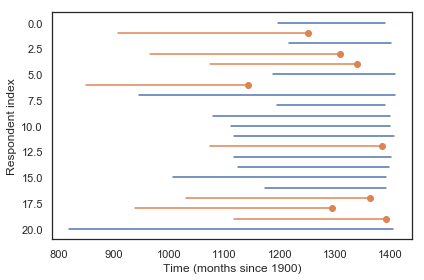

In [5]:
plot_lifelines('cmbirth', 'cmmarr1', 'cmintvw')
decorate(xlabel='Time (months since 1900)',
         ylabel='Respondent index')

In [6]:
ever_married = ~nsfg['cmmarr1'].isnull()
ever_married.value_counts()

False    2972
True     2582
Name: cmmarr1, dtype: int64

In [7]:
def decorate_surv(**kwargs):
    underride(kwargs,
              xlabel='Age (years)',
              ylabel='Survival curve')
    decorate(**kwargs)

In [8]:
def decorate_haz(**kwargs):
    underride(kwargs,
              xlabel='Age (years)',
             ylabel='Hazard function')
    decorate(**kwargs)

In [9]:
def decorate_cumhaz(**kwargs):
    underride(kwargs,
              xlabel='Age (years)',
             ylabel='Cumulative hazard function')
    decorate(**kwargs)

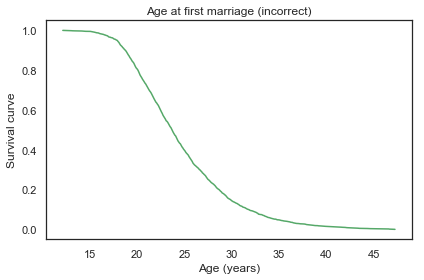

In [10]:
start = nsfg['cmbirth']
end = nsfg['cmmarr1']

duration = end[ever_married] - start[ever_married]
duration /= 12
surv_wrong = Surv.from_seq(duration)
surv_wrong.plot()

decorate_surv(title='Age at first marriage (incorrect)')

In [11]:
start = nsfg['cmbirth']
end1 = nsfg['cmmarr1']
end2 = nsfg['cmintvw']

nsfg.loc[ever_married, 'duration'] = end1[ever_married] - start[ever_married]
nsfg.loc[~ever_married, 'duration'] = end2[~ever_married] - start[~ever_married]
nsfg['duration'] /= 12

In [12]:
def kaplan_meier(T, E, **kwargs):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    """
    if np.sum(np.isnan(T)):
        raise ValueError("T contains NaNs")

    # how many complete and how many ongoing at each time
    pmf_complete = Pmf.from_seq(T[E], normalize=False)
    pmf_ongoing = Pmf.from_seq(T[~E], normalize=False)

    # compute the total "at risk" at the beginning,
    # and the set union of the event times
    S = pd.Series.add(pmf_complete, pmf_ongoing, fill_value=0)
    at_risk = S.sum()

    # initialize the Hazard object
    haz = Hazard(index=S.index, **kwargs)

    for t in S.index:
        ended = pmf_complete[t]
        censored = pmf_ongoing[t]
        haz[t] = ended / at_risk
        at_risk -= ended + censored

    return haz

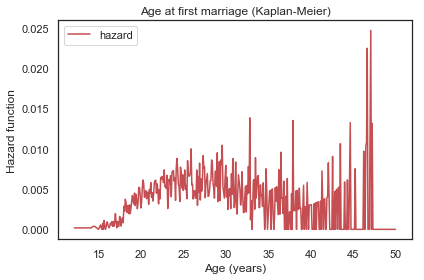

In [13]:
haz = kaplan_meier(T=nsfg['duration'], E=ever_married, name='hazard')
haz.plot()

decorate_haz(title='Age at first marriage (Kaplan-Meier)')

In [14]:
complete = [1,3,6]
ongoing = [2,3,5]

pmf_complete = Pmf.from_seq(complete, normalize=False)
pmf_ongoing = Pmf.from_seq(ongoing, normalize=False)

S = pd.Series.add(pmf_complete, pmf_ongoing, fill_value=0)
total = S.sum()

complement = total - S.cumsum()

R = pd.Series(np.roll(complement, 1), index=complement.index)
R.iloc[0] = total

lam = pd.Series.div(pmf_complete, R, fill_value=0)

df = pd.DataFrame(index=lam.index)
df['pmf_complete'] = pmf_complete
df['pmf_ongoing'] = pmf_ongoing
df['sum'] = S
df['complement'] = complement
df['at risk'] = R
df['hazard'] = lam
df

,pmf_complete,pmf_ongoing,sum,complement,at risk,hazard
1,1.0,NaN,1.0,5.0,6.0,0.166667
2,NaN,1.0,1.0,4.0,5.0,0.000000
3,1.0,1.0,2.0,2.0,4.0,0.250000
5,NaN,1.0,1.0,1.0,2.0,0.000000
6,1.0,NaN,1.0,0.0,1.0,1.000000


In [15]:
def kaplan_meier(T, E, **kwargs):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    """
    if np.sum(np.isnan(T)):
        raise ValueError("T contains NaNs")

    pmf_complete = Pmf.from_seq(T[E], normalize=False)
    pmf_ongoing = Pmf.from_seq(T[~E], normalize=False)

    S = pd.Series.add(pmf_complete, pmf_ongoing, fill_value=0)
    total = S.sum()

    complement = total - S.cumsum()

    R = pd.Series(np.roll(complement, 1), index=complement.index)
    R.iloc[0] = total

    lam = pd.Series.div(pmf_complete, R, fill_value=0)

    return Hazard(lam, **kwargs)

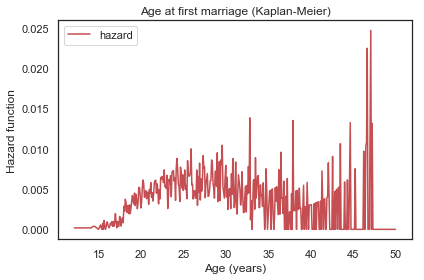

In [16]:
haz2 = kaplan_meier(T=nsfg['duration'], E=ever_married, name='hazard')
haz2.plot()

decorate_haz(title='Age at first marriage (Kaplan-Meier)')

In [17]:
max(abs(haz-haz2))

0.0

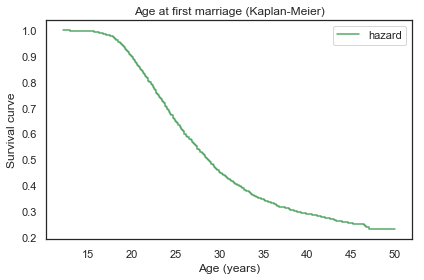

In [18]:
surv = haz.make_surv()
surv.step()

decorate_surv(title='Age at first marriage (Kaplan-Meier)')

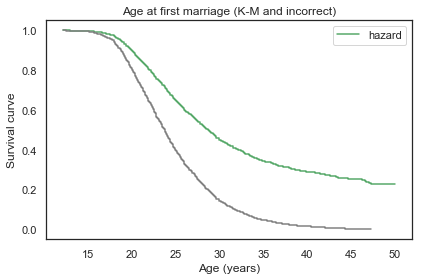

In [19]:
surv = haz.make_surv()
surv.step()
surv_wrong.step(color='gray')

decorate_surv(title='Age at first marriage (K-M and incorrect)')

In [20]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [21]:
kmf.fit(nsfg['duration'], event_observed=ever_married)

<lifelines.KaplanMeierFitter: fitted with 5554 observations, 2972 censored>

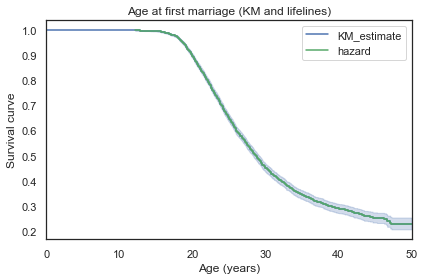

In [22]:
kmf.plot()
surv.step()

decorate_surv(title='Age at first marriage (KM and lifelines)')

In [23]:
nsfg['cmbirth'].median()

1030.0

In [24]:
80 * 12

960

In [25]:
pre1980 = nsfg['cmbirth'] < 80 * 12

In [26]:
def plot_estimated_surv(T, E, **kwargs):
    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=E)
    kmf.plot(**kwargs)

In [27]:
%psource kmf.plot

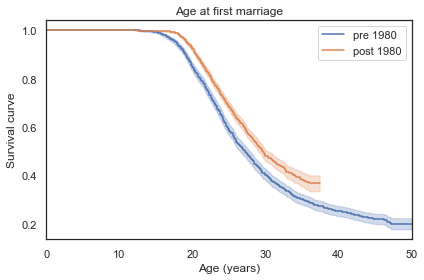

In [28]:
plot_estimated_surv(nsfg.loc[pre1980, 'duration'], 
                    ever_married[pre1980],
                    label='pre 1980')

plot_estimated_surv(nsfg.loc[~pre1980, 'duration'], 
                    ever_married[~pre1980],
                    label='post 1980',
                    ax=plt.gca())

decorate_surv(title='Age at first marriage')

### Divorce

In [29]:
subset = nsfg.loc[ever_married].copy()

In [30]:
divorced = ~subset['cmdiss1'].isnull()
divorced.value_counts()

False    1543
True     1039
Name: cmdiss1, dtype: int64

In [31]:
start = subset['cmmarr1']
end1 = subset['cmdiss1']
end2 = subset['cmintvw']

subset.loc[divorced, 'duration'] = end1[divorced] - start[divorced]
subset.loc[~divorced, 'duration'] = end2[~divorced] - start[~divorced]
subset['duration'] /= 12

In [32]:
subset['duration'].describe()

count    2582.000000
mean        8.468952
std         6.944597
min        -0.916667
25%         2.833333
50%         6.666667
75%        12.645833
max        33.666667
Name: duration, dtype: float64

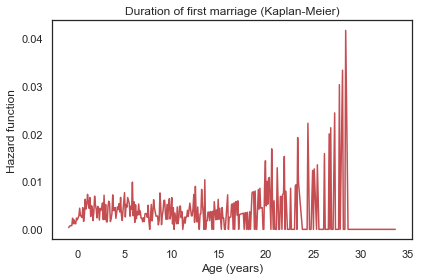

In [33]:
haz = kaplan_meier(T=subset['duration'], E=divorced)
haz.plot()

decorate_haz(title='Duration of first marriage (Kaplan-Meier)')

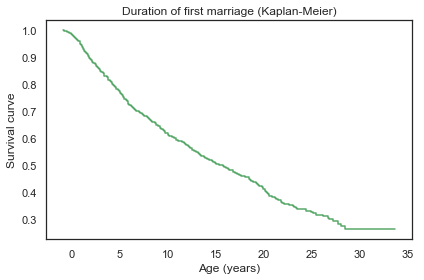

In [34]:
surv = haz.make_surv()
surv.step()

decorate_surv(title='Duration of first marriage (Kaplan-Meier)')

In [35]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(subset['duration'], event_observed=divorced)

<lifelines.KaplanMeierFitter: fitted with 2582 observations, 1543 censored>

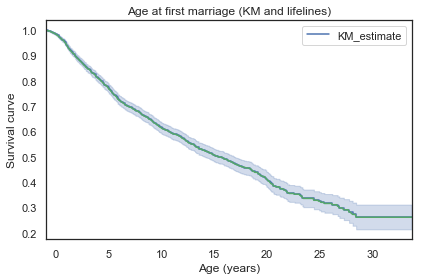

In [36]:
kmf.plot()
surv.plot()

decorate_surv(title='Age at first marriage (KM and lifelines)')

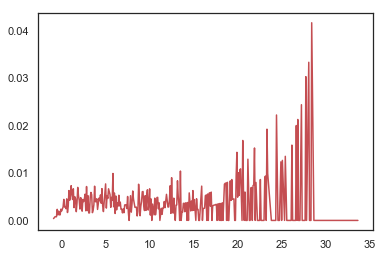

In [37]:
haz.plot()

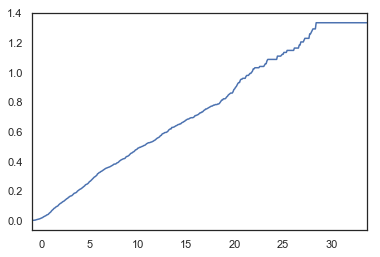

In [38]:
cumulative_haz = haz.cumsum()
cumulative_haz.plot()

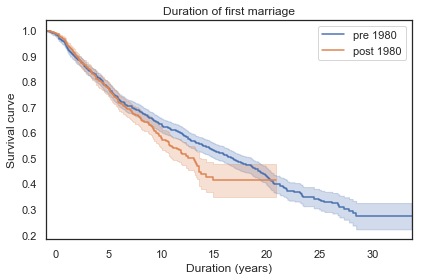

In [40]:
pre1980 = subset['cmbirth'] < 80 * 12

plot_estimated_surv(subset.loc[pre1980, 'duration'], 
                    divorced[pre1980],
                    label='pre 1980')

plot_estimated_surv(subset.loc[~pre1980, 'duration'], 
                    divorced[~pre1980],
                    label='post 1980',
                    ax=plt.gca())

decorate_surv(xlabel='Duration (years)',
              ylabel='Survival curve',
              title='Duration of first marriage')